<a href="https://colab.research.google.com/github/alessandrotofani/Tesi_magistrale/blob/master/3_Neural_Net_new_BatchNorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys 
sys.path.append('/content/drive/MyDrive/Tesi_magistrale/Tesi_magistrale')
import mf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
!pip install --quiet fastai==2.2.5

# Preprocessing

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv')
data = mf.new_processing(data)
# data = pd.get_dummies(data)

In [5]:
cols = mf.get_col(data)

In [6]:
from fastai.tabular.all import *

In [7]:
categorical_col = data.select_dtypes(include=['object']).columns.tolist()

In [8]:
def get_numerical_col(data, categorical_col):
  numerical_col = []
  for col in data.columns:
    if col not in categorical_col and col != 'isFraud':
      numerical_col.append(col)
  return numerical_col

numerical_col = get_numerical_col(data, categorical_col)

Tutorial: https://docs.fast.ai/tutorial.tabular.html

Book: https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb

In [9]:
fasted = TabularPandas(data, procs=[Categorify],
                   cat_names = categorical_col,
                   cont_names = numerical_col,
                   y_names='isFraud')
                  #  splits=splits)

In [10]:
X_train, y_train = fasted.xs, fasted.ys.values.ravel()
# X_test, y_test = fasted.valid.xs, fasted.valid.ys.values.ravel()

In [11]:
# for col in categorical_col:
#   print('Feature',col, 'has',X_train[col].max(), 'different categorical values')

In [12]:
categorical_col_toemb = []
one_hot_encode = []
for col in categorical_col:
  if X_train[col].max() > 7:
    categorical_col_toemb.append(col)
  else:
    one_hot_encode.append(col)

X_train = pd.get_dummies(X_train, columns=one_hot_encode)
cols = mf.get_col(X_train)

In [13]:
numerical_col = get_numerical_col(X_train, categorical_col_toemb)

## Train validation test split

Splitto il dataset in train, validation e test set. 

In [14]:
def overSampling(X, y, frac_over=0.1):
  from imblearn.over_sampling import SMOTE
  sm = SMOTE(sampling_strategy=frac_over, random_state=42)
  X_sm, y_sm = sm.fit_resample(X, y)  
  return X_sm, y_sm

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2)
X_train, y_train = overSampling(X_train, y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [16]:
save_id = False 

if save_id:
  train_id = X_train.index.tolist()
  val_id = X_val.index.tolist()
  test_id = X_test.index.tolist()
  mf.save_list('train_id',train_id)
  mf.save_list('val_id', val_id)
  mf.save_list('test_id', test_id)

load_id = False 
if load_id:
  mf.load_list('train_id',train_id)
  mf.load_list('val_id', val_id)
  mf.load_list('test_id', test_id)

# Neural Network

Kaggle tutorial https://www.kaggle.com/colinmorris/embedding-layers

Implementation: https://www.kaggle.com/blaskowitz100/dnn-keras-and-categorical-feature-embedding

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers

keras.backend.clear_session()
# Embedding for categorical features
categorical_input = []
numerical_input = []
embeddings = []
embedding_layer_names = []
for col in categorical_col_toemb:
# for col in categorical_col:
    _input = layers.Input(shape=[1], name=col)
    _embed = layers.Embedding(fasted[col].max() + 1, 3, name=col+'_emb')(_input)
    categorical_input.append(_input)
    embeddings.append(_embed)
    embedding_layer_names.append(col+'_emb')
    
# Simple inputs for the numeric features
for col in numerical_col:
    numeric_input = layers.Input(shape=(1,), name=col)
    numerical_input.append(numeric_input)
    
# Merge the numeric inputs
merged_num_inputs = layers.concatenate(numerical_input)

# Merge embedding and use a Droput to prevent overfittting
merged_inputs = layers.concatenate(embeddings)
spatial_dropout = layers.SpatialDropout1D(0.5)(merged_inputs)
flat_embed = layers.Flatten()(spatial_dropout)

# Merge embedding and numeric features
all_features = layers.concatenate([flat_embed, merged_num_inputs])

# MLP for classification
# x = layers.Dense(512, activation=tf.keras.activations.gelu)(all_features)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation=tf.keras.activations.gelu)(all_features)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation=tf.keras.activations.gelu)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation=tf.keras.activations.gelu)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation=tf.keras.activations.gelu)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(16, activation=tf.keras.activations.gelu)(x)
x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.2)(x)
# x = layers.Dense(8, activation=tf.keras.activations.gelu)(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.2)(x)
# x = layers.Dense(4, activation=tf.keras.activations.gelu)(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.2)(x)

# Final model
output = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs=categorical_input + numerical_input, outputs=output)

In [30]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
# print(model.summary())

In [31]:
def get_keras_dataset(X, cols):
  df = pd.DataFrame(data=X, columns=cols)
  X = {str(col) : np.array(df[col]) for col in df.columns}
  return X

In [32]:
history = model.fit(
    get_keras_dataset(X_train, cols), 
    y_train,
    epochs=30, 
    batch_size=512, # 2048 1024 512
    validation_data=(get_keras_dataset(X_val, cols),y_val),
    verbose=1,
    shuffle = True , #class_weight = {0: 1, 1: ratio / 2}
)

Epoch 1/30
735/735 [==============================] - 26s 31ms/step - loss: 0.4632 - accuracy: 0.8177 - recall: 0.3238 - precision: 0.2306 - val_loss: 0.2376 - val_accuracy: 0.9149 - val_recall: 0.3448 - val_precision: 0.5524
Epoch 2/30
735/735 [==============================] - 21s 29ms/step - loss: 0.2270 - accuracy: 0.9203 - recall: 0.2204 - precision: 0.6862 - val_loss: 0.2116 - val_accuracy: 0.9261 - val_recall: 0.2781 - val_precision: 0.7552
Epoch 3/30
735/735 [==============================] - 22s 30ms/step - loss: 0.2142 - accuracy: 0.9239 - recall: 0.2736 - precision: 0.7171 - val_loss: 0.2023 - val_accuracy: 0.9269 - val_recall: 0.2482 - val_precision: 0.8286
Epoch 4/30
735/735 [==============================] - 21s 29ms/step - loss: 0.2056 - accuracy: 0.9264 - recall: 0.3017 - precision: 0.7250 - val_loss: 0.1951 - val_accuracy: 0.9325 - val_recall: 0.3626 - val_precision: 0.7777
Epoch 5/30
735/735 [==============================] - 21s 29ms/step - loss: 0.1983 - accuracy: 0

# Performance evaluation

In [33]:
# test_loss, test_acc = model.evaluate(get_keras_dataset(X_test, cols), y_test)

# print()
# print('Test Loss:\t', test_loss)
# print('Test Accuracy:\t', test_acc)

In [34]:
y_pred = model.predict(get_keras_dataset(X_test, cols))

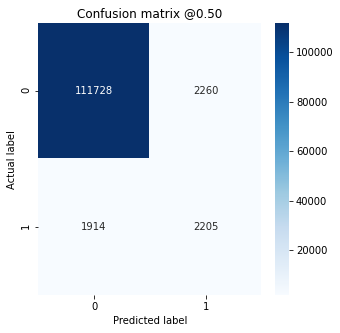

In [35]:
mf.plot_cm(y_test, y_pred, 'Blues')

AUC:  0.9008414180106936


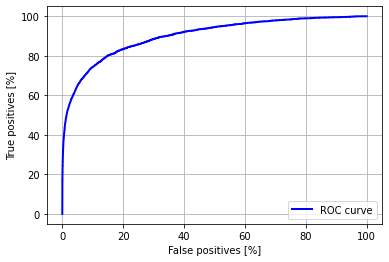

In [36]:
mf.plot_roc("ROC curve", y_test, y_pred,color='blue')

Average precision:  0.5430512964523844


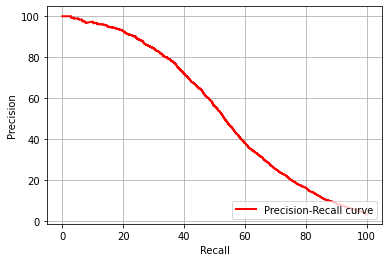

In [37]:
mf.plot_ap('Precision-Recall curve', y_test, y_pred, color = 'red')

In [38]:
y_predicted = []
for prob in y_pred:
  if prob >= 0.5:
    y_predicted.append(1)
  else:
    y_predicted.append(0)

In [39]:
from sklearn.metrics import f1_score, recall_score, precision_score
print('F1 score: ',f1_score(y_test, y_predicted, average="binary"))
print('Recall: ', recall_score(y_test, y_predicted, average='binary'))
print('Precision: ', precision_score(y_test, y_predicted,  average='binary'))

F1 score:  0.5137465051258154
Recall:  0.5353241077931536
Precision:  0.49384098544232924
